# Age Prediction Modeling

This Notebook has the goal of creating a ML Model that is able to accurately predict whether someone that is arrested is Los Angeles will fall between two Age Groups: Younger Adults (18-33) and Older Adults (33+).

The threshold value is equivalent to the median Age from the dataset.

This model is part of a bigger project that aims to predict the Demographics of a criminal in L.A., including Age, Gender, and Ethnicity.

### Table of Contents

- Some data cleaning and preparing the data for modeling
- Applying SMOTE to the training datasets
- Running GridSearchCV to find the best hyperparameters for each model when applicable

- XGBoost Model
- Decision Tree Model
- VotingClassifier
  - Soft and Hard Voting
  - Ensemble of XGBoost and Decision Tree
- Some analysis on the XGBoost model (Best performing model)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Some extra data cleaning and engineering

## Separate Date column into multiple columns & group up different Ethnicities into smaller groups

In [ ]:
clean_df = pd.read_csv('/content/drive/Shareddrives/Project 3 (Arrest Dataset)/clean_arrest_data.csv')

clean_df_engineered = clean_df.copy()

# Convert the date columns to datetime format
clean_df_engineered['Arrest_DateTime'] = pd.to_datetime(clean_df_engineered['Arrest Date'], errors='coerce')
clean_df_engineered['Booking_DateTime'] = pd.to_datetime(clean_df_engineered['Booking Date'], errors='coerce')

# Extract day, month, and year for Arrest Date
clean_df_engineered['Arrest_Day'] = clean_df_engineered['Arrest_DateTime'].dt.day
clean_df_engineered['Arrest_Month'] = clean_df_engineered['Arrest_DateTime'].dt.month
clean_df_engineered['Arrest_Year'] = clean_df_engineered['Arrest_DateTime'].dt.year

# Extract day, month, and year for Booking Date
clean_df_engineered['Booking_Day'] = clean_df_engineered['Booking_DateTime'].dt.day
clean_df_engineered['Booking_Month'] = clean_df_engineered['Booking_DateTime'].dt.month
clean_df_engineered['Booking_Year'] = clean_df_engineered['Booking_DateTime'].dt.year

clean_df_engineered = clean_df_engineered.drop(columns=['Arrest Date', 'Booking Date', 'Arrest_DateTime', 'Booking_DateTime'])

# Updated mapping dictionary for recoding
descent_mapping = {
    # Hispanic/Latino
    'H': 'Hispanic/Latino',

    # Black/African American
    'B': 'Black/African American',

    # White/Caucasian
    'W': 'White/Caucasian',

    # Asian/Pacific Islander (combining Asian and Pacific Islander)
    'A': 'Other/Unknown',
    'C': 'Other/Unknown',
    'F': 'Other/Unknown',
    'K': 'Other/Unknown',
    'J': 'Other/Unknown',
    'Z': 'Other/Unknown',
    'D': 'Other/Unknown',
    'V': 'Other/Unknown',
    'L': 'Other/Unknown',
    'G': 'Other/Unknown',  # Guamanian
    'P': 'Other/Unknown',  # Pacific Islander
    'U': 'Other/Unknown',  # Hawaiian
    'S': 'Other/Unknown',  # Samoan

    # Other/Unknown (including Native American due to small numbers)
    'I': 'Other/Unknown',  # American Indian/Alaska Native
    'O': 'Other/Unknown',
    'X': 'Other/Unknown'
}

# Apply the mapping to create a new column
clean_df_engineered['Ethnicity'] = clean_df_engineered['Descent Code'].map(descent_mapping)

# Check the distribution of the new ethnicity categories
print("Ethnicity Distribution:")
print(clean_df_engineered['Ethnicity'].value_counts())
print(clean_df_engineered['Ethnicity'].value_counts(normalize=True).map('{:.1%}'.format))

clean_df_engineered = clean_df_engineered.drop(columns=['Descent Code'])

<ipython-input-178-2864552c46c4>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clean_df_engineered['Arrest_DateTime'] = pd.to_datetime(clean_df_engineered['Arrest Date'], errors='coerce')
<ipython-input-178-2864552c46c4>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clean_df_engineered['Booking_DateTime'] = pd.to_datetime(clean_df_engineered['Booking Date'], errors='coerce')


Ethnicity Distribution:
Ethnicity
Hispanic/Latino           159620
Black/African American     84918
White/Caucasian            49060
Other/Unknown              18368
Name: count, dtype: int64
Ethnicity
Hispanic/Latino           51.2%
Black/African American    27.2%
White/Caucasian           15.7%
Other/Unknown              5.9%
Name: proportion, dtype: object


## Categorize Charge Description Column into Crime Type for easier data manipulation

In [ ]:
# define crime categories based on keywords
def categorize_charge(description):
    description = str(description).lower()

    if any(word in description for word in ['theft', 'shoplifting', 'robbery', 'burglary', 'larceny', 'stolen', 'pickpocket', 'breaking and entering']):
        return 'Theft & Robbery'
    elif any(word in description for word in ['assault', 'battery', 'homicide', 'murder', 'manslaughter', 'domestic violence', 'corporal injury', 'domestic viol', 'domestic relations']):
        return 'Violent Crimes'
    elif any(word in description for word in ['drug', 'narcotic', 'possession', 'paraphernalia', 'trafficking', 'distribution', 'alcohol', 'drinking', 'substance', 'sell controlled', 'purchase controlled', 'marijuana']):
        return 'Drug & Alchol Related'
    elif any(word in description for word in ['fraud', 'forgery', 'embezzlement', 'identity theft', 'bribery', 'money laundering', 'gambling']):
        return 'Fraud & Financial Crimes'
    elif any(word in description for word in ['dui', 'dwi', 'drunk driving', 'reckless driving', 'hit and run', 'vehicular','vehicle', 'drive priv', 'under influence']):
        return 'DUI & Traffic Violations'
    elif any(word in description for word in ['vandalism', 'trespassing', 'arson', 'property damage', 'graffiti', 'railroad', 'leave property', 'property']):
        return 'Property Crimes'
    elif any(word in description for word in ['firearm', 'weapon', 'gun', 'illegal possession', 'unlawful discharge', 'trafficking', 'poss f/', 'carry']):
        return 'Weapons Offenses'
    elif any(word in description for word in ['prostitution', 'solicitation', 'sex', 'indecent exposure', 'sexual assault', 'rape']):
        return 'Sex Crimes'
    elif any(word in description for word in ['warrant', 'failure to appear', 'bench warrant', 'fugitive', 'parole violation', 'violation of parole', 'code']):
        return 'Warrant & Legal Violations'
    elif any(word in description for word in ['public intoxication', 'disorderly conduct', 'disturbing the peace', 'loitering', 'curfew', 'terrorize', 'batt', 'loiter']):
        return 'Public Order Crimes'
    elif any(word in description for word in ['obstruction', 'obstruct', 'resisting arrest', 'perjury', 'contempt', 'harboring fugitive', 'safety']):
        return 'Obstruction of Justice'
    elif any(word in description for word in ['cyber', 'hacking', 'phishing', 'identity fraud', 'online scam']):
        return 'Cyber Crimes'
    else:
        return 'Other Crimes'

# apply the function
clean_df_engineered['Crime Category'] = clean_df_engineered['Charge Description'].apply(categorize_charge)

# Modeling

## Preparing data for modeling (Label Encoding, Age Groups, SMOTE, Split Train and Test Data)

In [ ]:
# Create a copy for modeling
modeling_df = clean_df_engineered.copy()

# Convert categorical features to numerical using LabelEncoder
categorical_columns = ['Area Name', 'Charge Group Description', 'Arrest Type Code',
                       'Charge', 'Charge Description', 'Crime Category', 'Disposition Description','Report Type', 'Address', 'Location', 'Booking Location', 'Ethnicity', 'Sex Code']

label_encoders = {}
for col in categorical_columns:
    if col in modeling_df.columns:
        le = LabelEncoder()
        modeling_df[col] = le.fit_transform(modeling_df[col])
        label_encoders[col] = le


# Define binary age groups
# Cutoff at Age 33, this is the median age in the data.
def categorize_age_binary(age):
    if age <= 33:
        return 0  # Younger Adults (18-33)
    else:
        return 1  # Older Adults (33+)

# Apply the function to create target variable
modeling_df['Age_Group'] = modeling_df['Age'].apply(categorize_age_binary)

# Verify distribution
print("Binary Age Group Distribution:")
print(modeling_df['Age_Group'].value_counts())
print(modeling_df['Age_Group'].value_counts(normalize=True).map('{:.1%}'.format))

# Setup features and target for binary classification
X = modeling_df.drop(columns=['Age', 'Age_Group', 'Report ID', 'Location',
                              'Booking_Day', 'Arrest_Day', 'Reporting District', 'Area ID'])
y = modeling_df['Age_Group']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to generate synthetic samples
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Binary Age Group Distribution:
Age_Group
0    158001
1    153965
Name: count, dtype: int64
Age_Group
0    50.6%
1    49.4%
Name: proportion, dtype: object


### Helpful function to print metrics and feature importance for the models

In [ ]:
def printModelInfo(preds, title, model, X_test, y_test, X, top_n=5):
    """
    Extended function to print model metrics, confusion matrix, and feature importance
    with larger font sizes for better readability

    Parameters:
    -----------
    preds : array-like
        Predicted values from the model
    title : str
        Title for the plots
    model : estimator object
        The trained model
    X_test : array-like
        Test features
    y_test : array-like
        True target values
    X : DataFrame
        Original feature DataFrame (to get column names)
    top_n : int, optional
        Number of top features to display, by default 5
    """
    # Set global font size for better readability
    plt.rcParams.update({'font.size': 18, 'font.weight': 'bold'})

    # Ensure we have feature names
    feature_names = X.columns.tolist()

    # Class names for the confusion matrix
    class_names = ['Younger Adults', 'Older Adults']

    # Calculate accuracy
    acc = accuracy_score(y_test, preds)
    print(f"{title} Accuracy: {acc:.4f}")

    # Calculate detailed metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average=None)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Calculate AUC-ROC if applicable
    if hasattr(model, "predict_proba"):
        try:
            y_pred_proba = model.predict_proba(X_test)[:,1]
            auc = roc_auc_score(y_test, y_pred_proba)
            print(f"AUC-ROC: {auc:.4f}")
        except:
            print("AUC-ROC: Not available")

    # Create confusion matrix with larger font sizes
    cm = confusion_matrix(y_test, preds, normalize='true')
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 16})
    plt.xlabel('Predicted Outcome', fontsize=16)
    plt.ylabel('Actual Outcome', fontsize=16)
    plt.title(f'{title}', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

    # Feature importance for different model types
    importance_df = None

    # For logistic regression and similar models
    if hasattr(model, 'coef_'):
        try:
            coefficients = model.coef_[0]
            # Make sure feature_names and coefficients match in length
            if len(feature_names) == len(coefficients):
                importance_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': np.abs(coefficients)
                })
                print(f"\n{title} - Feature Importance (Coefficients):")
            else:
                print(f"Length mismatch fixed: features ({len(feature_names)}) vs coefficients ({len(coefficients)})")
                # Try to directly use the feature count from coefficients
                if len(coefficients) > 0:
                    importance_df = pd.DataFrame({
                        'Feature': [f'Feature {i}' for i in range(len(coefficients))],
                        'Importance': np.abs(coefficients)
                    })
                    print(f"\n{title} - Feature Importance (Coefficients) with generic feature names:")
        except Exception as e:
            print(f"Error in coefficient extraction: {str(e)}")

    # For tree-based models
    elif hasattr(model, 'feature_importances_'):
        try:
            importances = model.feature_importances_
            # Make sure feature_names and importances match in length
            if len(feature_names) == len(importances):
                importance_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': importances
                })
                print(f"\n{title} - Feature Importance:")
            else:
                print(f"Length mismatch fixed: features ({len(feature_names)}) vs importances ({len(importances)})")
                if len(importances) > 0:
                    importance_df = pd.DataFrame({
                        'Feature': [f'Feature {i}' for i in range(len(importances))],
                        'Importance': importances
                    })
                    print(f"\n{title} - Feature Importance with generic feature names:")
        except Exception as e:
            print(f"Error in feature importance extraction: {str(e)}")

    # For ensemble models that have sub-estimators
    elif hasattr(model, 'estimators_') and hasattr(model, 'named_estimators_'):
        try:
            for estimator_name, estimator in model.named_estimators_.items():
                if hasattr(estimator, 'coef_'):
                    coefficients = estimator.coef_[0]
                    if len(feature_names) == len(coefficients):
                        importance_df = pd.DataFrame({
                            'Feature': feature_names,
                            'Importance': np.abs(coefficients)
                        })
                        print(f"\n{title} - Feature Importance (from {estimator_name}):")
                        break
                    else:
                        if len(coefficients) > 0:
                            importance_df = pd.DataFrame({
                                'Feature': [f'Feature {i}' for i in range(len(coefficients))],
                                'Importance': np.abs(coefficients)
                            })
                            print(f"\n{title} - Feature Importance (from {estimator_name}) with generic feature names:")
                            break
                elif hasattr(estimator, 'feature_importances_'):
                    importances = estimator.feature_importances_
                    if len(feature_names) == len(importances):
                        importance_df = pd.DataFrame({
                            'Feature': feature_names,
                            'Importance': importances
                        })
                        print(f"\n{title} - Feature Importance (from {estimator_name}):")
                        break
                    else:
                        if len(importances) > 0:
                            importance_df = pd.DataFrame({
                                'Feature': [f'Feature {i}' for i in range(len(importances))],
                                'Importance': importances
                            })
                            print(f"\n{title} - Feature Importance (from {estimator_name}) with generic feature names:")
                            break
        except Exception as e:
            print(f"Error in ensemble model processing: {str(e)}")

    # For KNN and other models that don't have built-in feature importance
    else:
        print(f"\n{title} - Feature importance not available for this model type")

    # Display feature importance if available
    if importance_df is not None:
        importance_df = importance_df.sort_values('Importance', ascending=False)
        print(importance_df.head(top_n))

        # Plot feature importance with larger font sizes
        plt.figure(figsize=(16, 12))
        plt.barh(importance_df['Feature'].head(min(top_n, len(importance_df))),
                 importance_df['Importance'].head(min(top_n, len(importance_df))))
        plt.xlabel('Importance Value', fontsize=18)
        plt.ylabel('Feature', fontsize=18)
        plt.title(f'Feature Importance - {title}', fontsize=22)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.tight_layout()
        plt.show()

## XGBoost

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
# import seaborn as sns
# import xgboost as xgb

# # Define parameter grid for XGBoost
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7]
# }

# # Create base XGBoost model
# xgb_model = xgb.XGBClassifier(random_state=42)

# # Setup GridSearchCV
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='f1',
#     n_jobs=-1,
#     verbose=3
# )

# # Fit GridSearch to the training data
# grid_search.fit(X_train_resampled, y_train_resampled)

# # Get best parameters
# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

# # Train the model with best parameters
# best_xgb_model = grid_search.best_estimator_

# # Make predictions
# preds = best_xgb_model.predict(X_test)

# # Evaluate the model
# printModelInfo(preds, 'XGBoost (GridSearch)', best_xgb_model, X_test, y_test, X_train_resampled)

XGBoost Accuracy: 0.6331
Precision: [0.63668163 0.62935426]
Recall: [0.63860591 0.62740946]
F1 Score: [0.63764232 0.62838035]
AUC-ROC: 0.6904


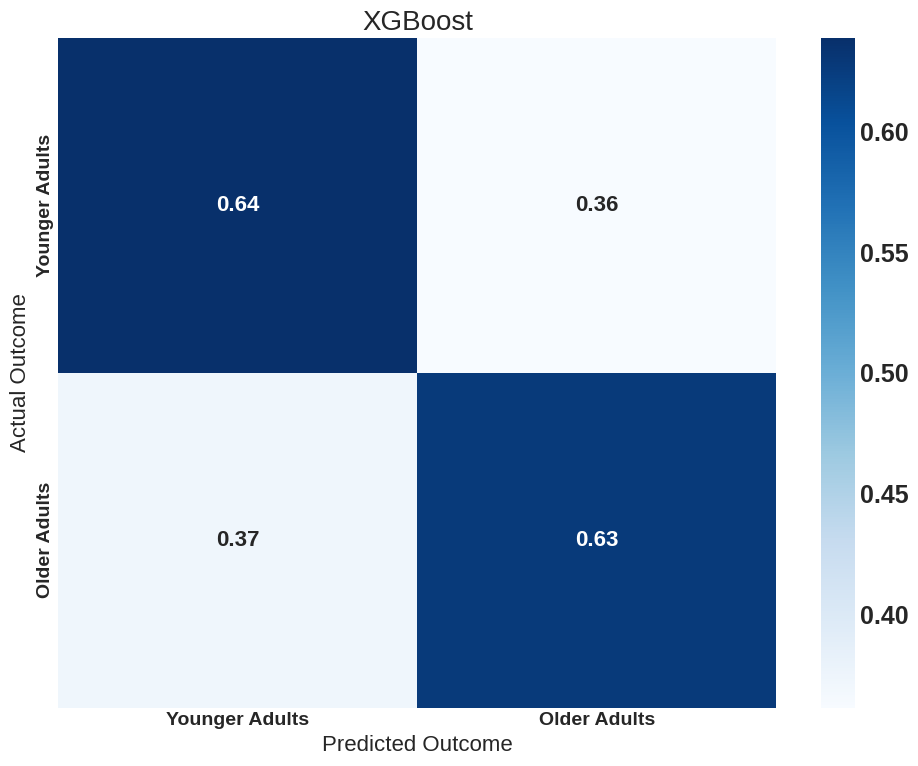


XGBoost - Feature Importance:
                     Feature  Importance
0                Report Type    0.175546
20                 Ethnicity    0.126549
5   Charge Group Description    0.092988
3                   Sex Code    0.085453
14          Booking Location    0.048226


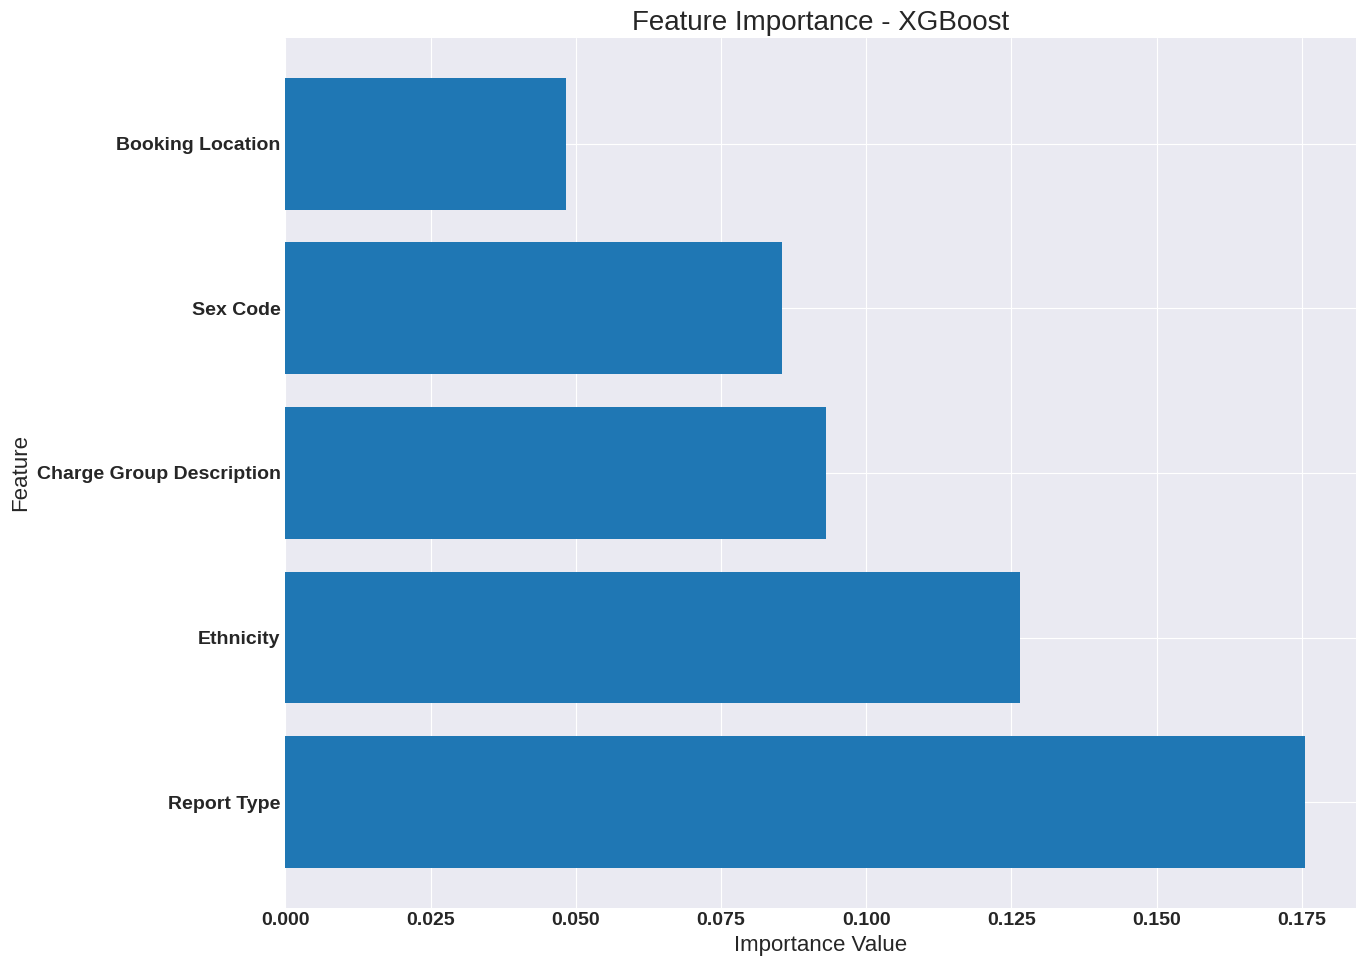

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import seaborn as sns
import xgboost as xgb

# Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    random_state=42
    )

# Train on the SMOTE training data
xgb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
xgb_preds = xgb_model.predict(X_test)

# Evaluate the model
printModelInfo(xgb_preds, 'XGBoost', xgb_model, X_test, y_test, X_train_resampled)

## Decision Tree

In [ ]:
# params = {
#     'max_depth': [2, 5, 10, 25, 50],
#     'min_samples_split': [5, 10, 25, 50, 100],
#     'min_samples_leaf': [5, 10, 25, 50, 100]
# }

# dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
# grid_search_dtc = GridSearchCV(
#     estimator=dt,
#     param_grid=params
# )

# grid_search_dtc.fit(X_train_resampled, y_train_resampled)

# print("\nBest parameters for model:")
# print(grid_search_dtc.best_params_)
# dt_best_model = grid_search_dtc.best_estimator_

# preds = dt_best_model.predict(X_test)

# dtc_acc = accuracy_score(y_test, preds)
# print(f"Decision Tree with GridSearchCV Accuracy: {logr_acc:.4f}")

# printMatrix(preds, 'Decision Tree', dt_best_model)

Decision Tree Accuracy: 0.5872
Precision: [0.58987798 0.58428032]
Recall: [0.60180919 0.57219725]
F1 Score: [0.59578386 0.57817566]
AUC-ROC: 0.6250


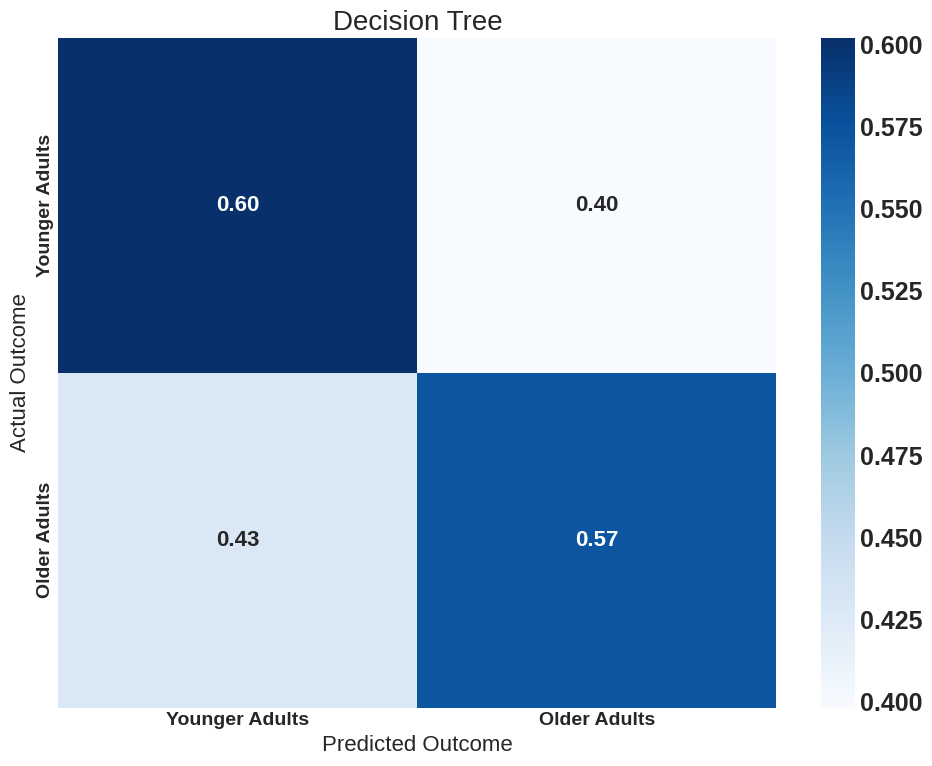


Decision Tree - Feature Importance:
         Feature  Importance
11           LAT    0.108336
12           LON    0.107355
13  Booking Time    0.104362
10       Address    0.098240
1           Time    0.088931


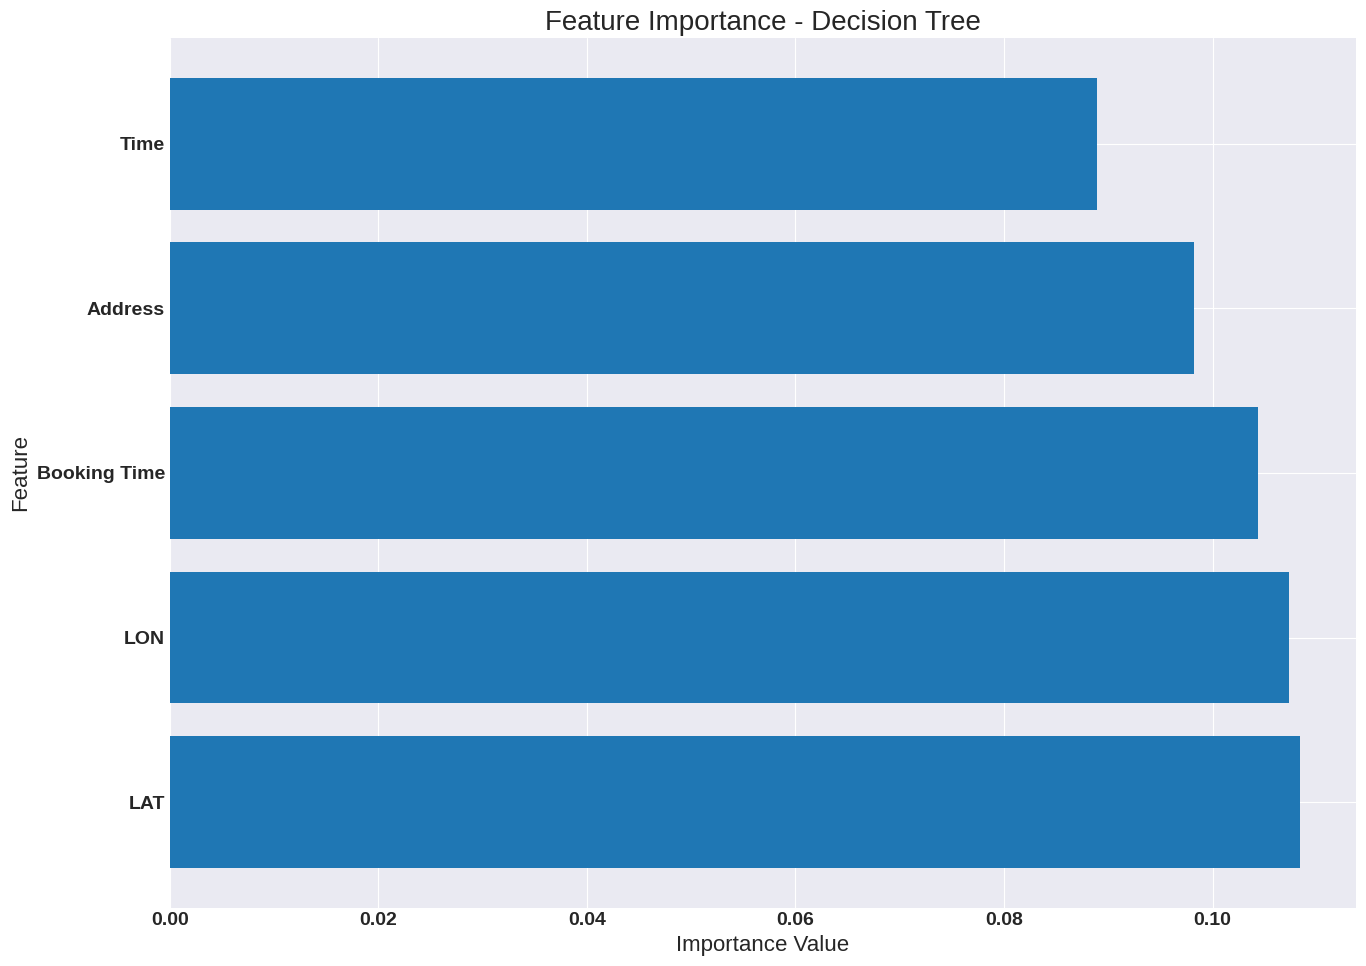

In [ ]:
# Best hyperparameters: {'max_depth': 25, 'min_samples_leaf': 5, 'min_samples_split': 50}
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=25, min_samples_split=50, min_samples_leaf=5)

dt.fit(X_train_resampled, y_train_resampled)

preds = dt.predict(X_test)

printModelInfo(preds, 'Decision Tree', dt, X_test, y_test, X_train_resampled)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier

# knn = KNeighborsClassifier(n_neighbors=5)

# knn.fit(X_train_resampled, y_train_resampled)
# # knn.fit(X_train, y_train)

# preds = knn.predict(X_test)

# printModelInfo(preds, 'Nearest Neighbors', knn, X_test, y_test, X_train_resampled)

## Voting Classifier (Ensemble)

Soft Voting Ensemble Accuracy: 0.6122
Precision: [0.61676837 0.60760012]
Recall: [0.61523016 0.60914945]
F1 Score: [0.61599831 0.6083738 ]
AUC-ROC: 0.6648


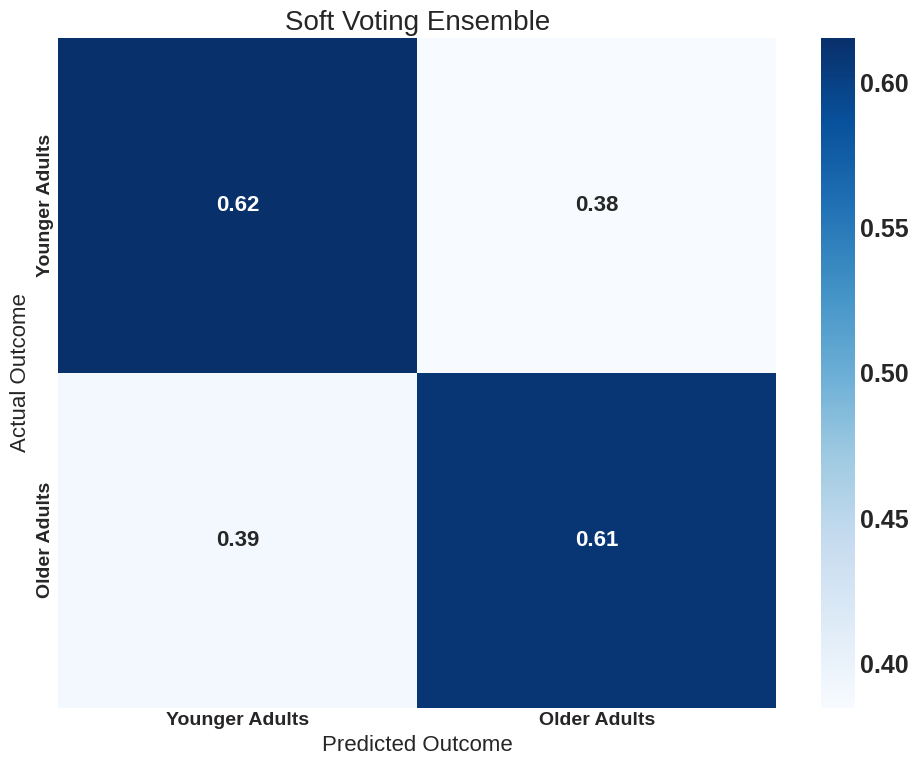


Soft Voting Ensemble - Feature Importance (from xgb):
                     Feature  Importance
0                Report Type    0.175546
20                 Ethnicity    0.126549
5   Charge Group Description    0.092988
3                   Sex Code    0.085453
14          Booking Location    0.048226


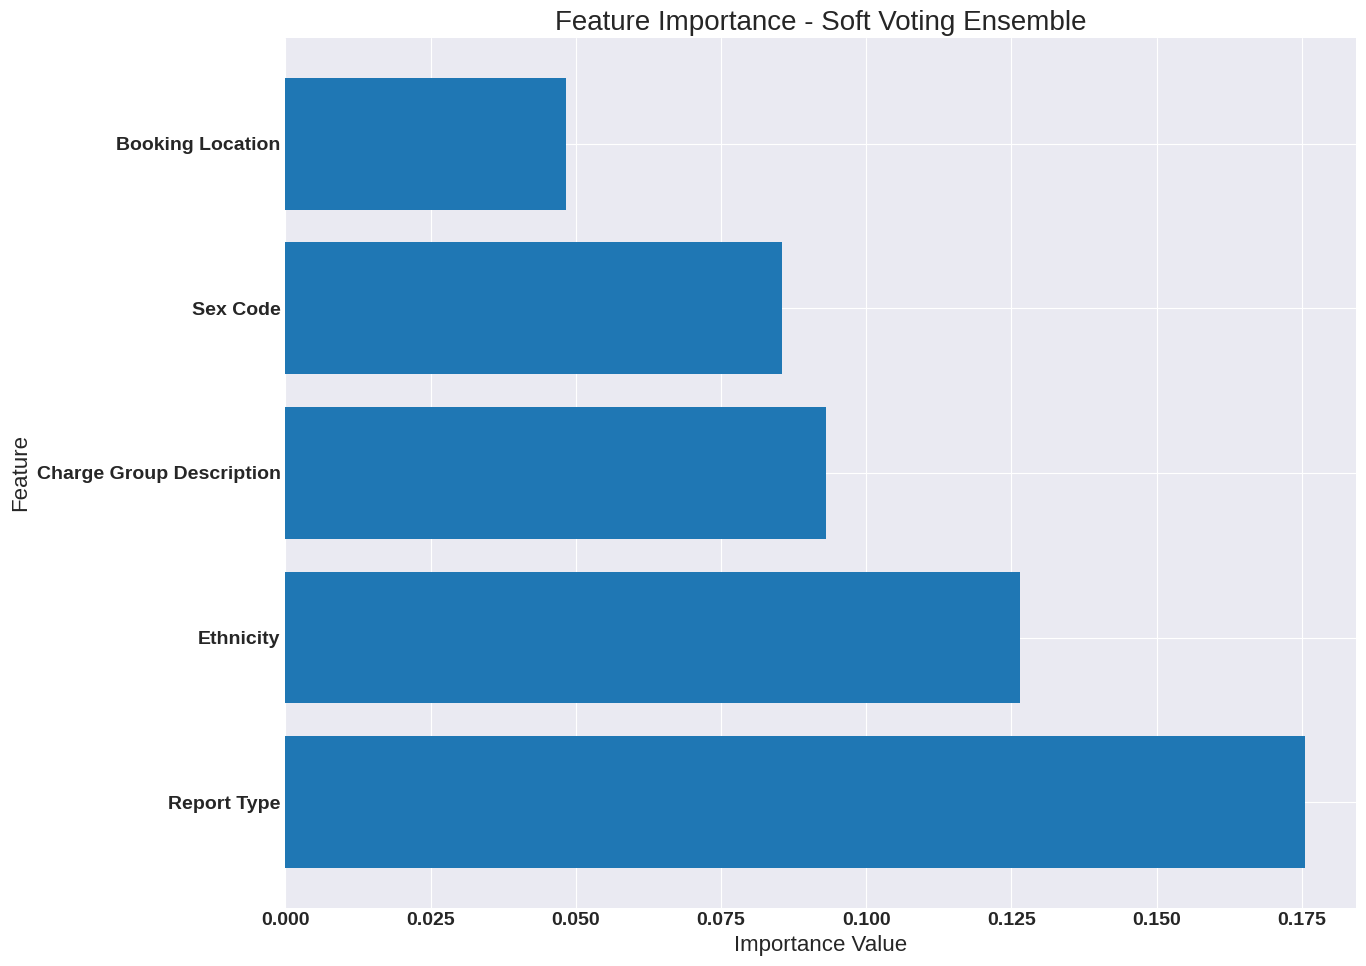

Hard Voting Ensemble Accuracy: 0.6106
Precision: [0.58764266 0.6558598 ]
Recall: [0.77049076 0.44720806]
F1 Score: [0.66675812 0.53180008]


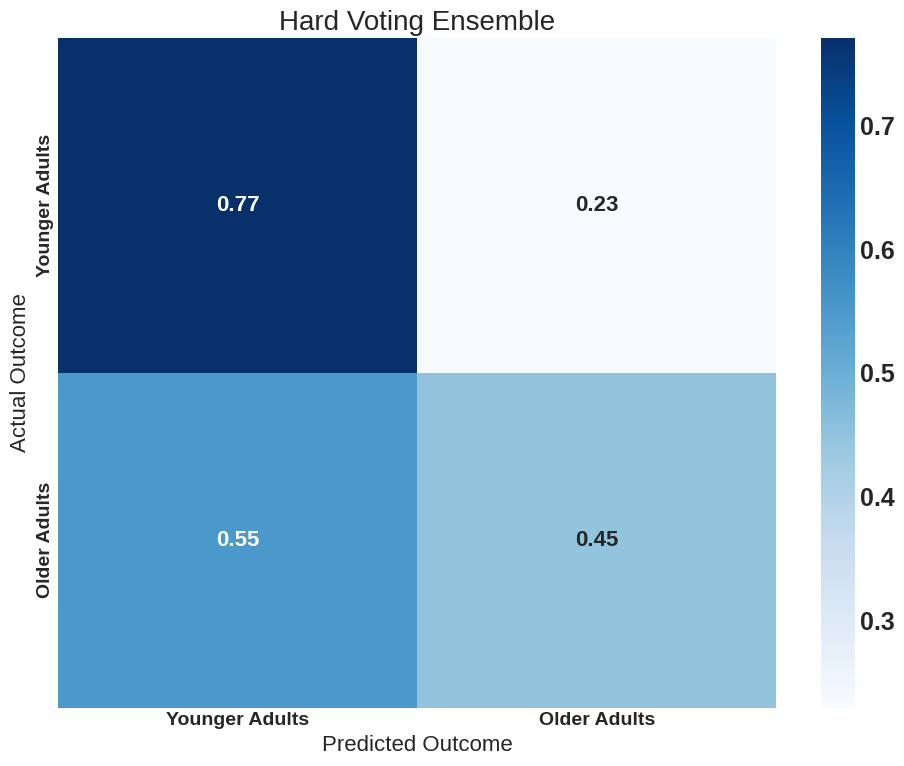


Hard Voting Ensemble - Feature Importance (from xgb):
                     Feature  Importance
0                Report Type    0.175546
20                 Ethnicity    0.126549
5   Charge Group Description    0.092988
3                   Sex Code    0.085453
14          Booking Location    0.048226


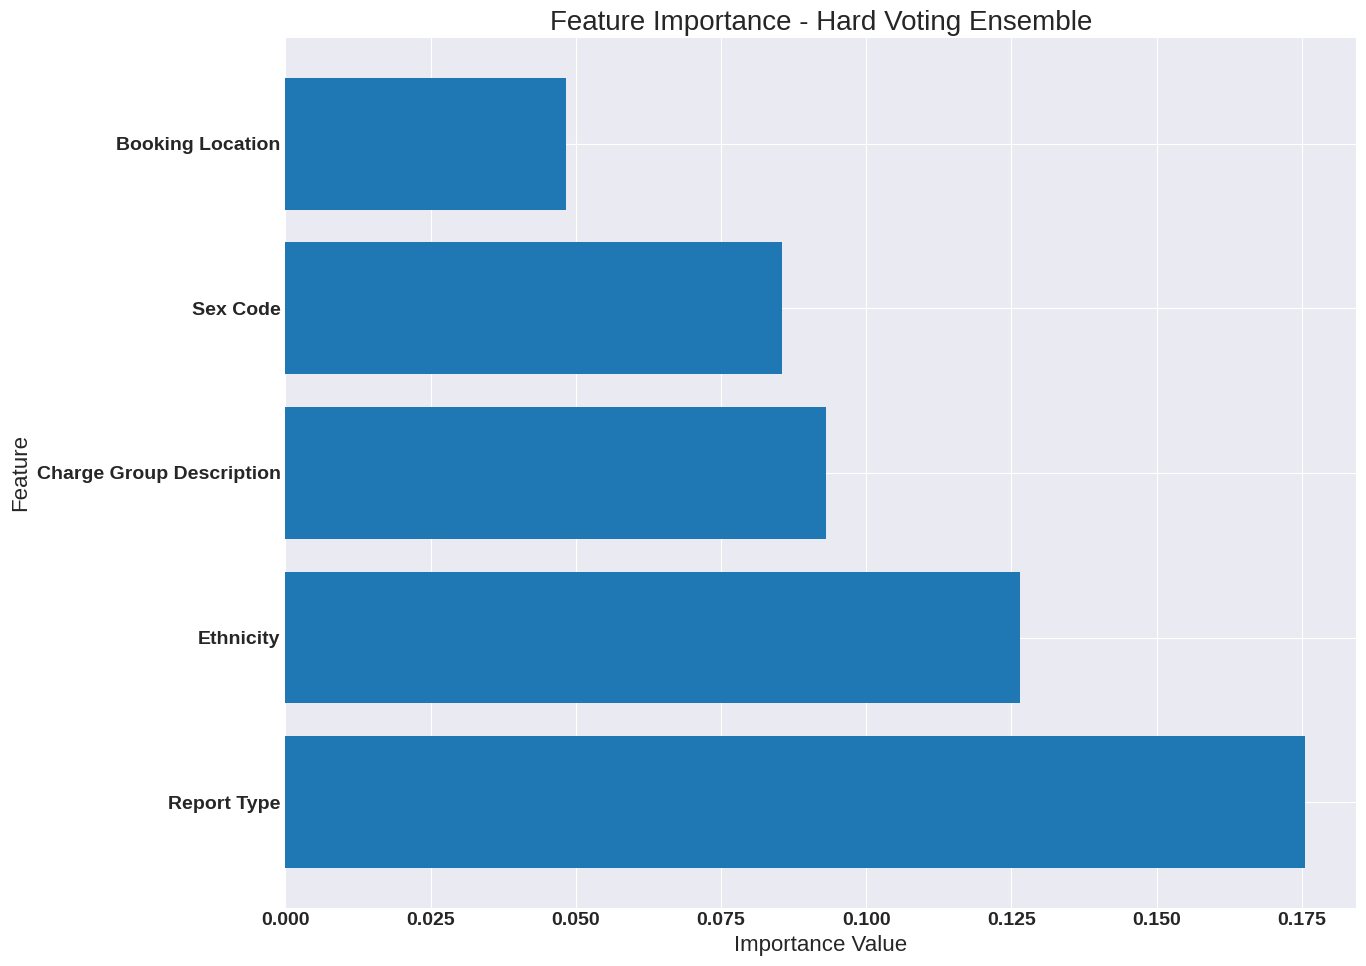

In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
        ('xgb', xgb_model), ('dt', dt)], voting='soft')
ensemble = ensemble.fit(X_train_resampled, y_train_resampled)
# ensemble = ensemble.fit(X_train, y_train)
preds = ensemble.predict(X_test)

printModelInfo(preds, 'Soft Voting Ensemble', ensemble, X_test, y_test, X_train_resampled)

ensemble = VotingClassifier(estimators=[
        ('xgb', xgb_model), ('dt', dt)], voting='hard')
ensemble = ensemble.fit(X_train_resampled, y_train_resampled)
# ensemble = ensemble.fit(X_train, y_train)
preds = ensemble.predict(X_test)

printModelInfo(preds, 'Hard Voting Ensemble', ensemble, X_test, y_test, X_train_resampled)

# Some analysis on the model

### Figure out the correlations with the Age column

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10})

def plot_correlations_excluding_target(df, target_column):
    # Create a copy of the dataframe without unwanted columns
    corrs_df = df.drop(columns=['Age_Group', 'Report ID', 'Location',
                              'Booking_Day', 'Arrest_Day', 'Reporting District', 'Area ID'])

    # Step 1: Compute correlations directly with target column
    correlations = corrs_df.corr(numeric_only=True)[target_column]

    # Step 2: Remove the target column's correlation with itself (which is 1.0)
    correlations = correlations.drop(target_column).sort_values()

    # Step 3: Plot as a bar graph
    plt.figure(figsize=(8,6))
    correlations.plot(kind='barh', color='skyblue')
    plt.title(f'Correlation of Features with {target_column}', fontweight='bold')
    plt.xlabel('Correlation Coefficient', fontweight='bold')
    plt.ylabel('Features', fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Print the actual correlation values
    print(f"Correlation values with {target_column}:")
    for feature, corr in correlations.items():
        print(f"{feature}: {corr:.4f}")

    return correlations

# Example usage:
correlations = plot_correlations_excluding_target(modeling_df, 'Ethnicity')

# Analyzing the results from XGBoost

In [ ]:
# First, let's add a unique identifier to keep track of rows
# If you don't already have a unique ID in your data, you can use the index
X_test_with_index = X_test.copy()
X_test_with_index['temp_index'] = X_test.index

# Create the result_df as you did before
result_df = X_test_with_index.copy()
result_df['actual_age_group'] = y_test
result_df['xgb_preds'] = xgb_preds

# Now get the Age column from the original dataframe
# Option 1: If you have the original indices preserved
age_data = modeling_df[['Age']].loc[result_df.index]

# Option 2: If you need to merge based on other columns
# Create a temporary dataframe with just the Age and any columns you need for merging
# This assumes you have some common columns between result_df and modeling_df
# age_data = modeling_df[['Age', 'common_column1', 'common_column2']]
# result_df = result_df.merge(age_data, on=['common_column1', 'common_column2'], how='left')

# Add the Age column to your result_df
result_df['Age'] = age_data

# Continue with your code to add labels and reverse encoding
age_group_labels = {0: "Younger Adults (≤33)", 1: "Older Adults (>33)"}
result_df['xgb_preds_label'] = result_df['xgb_preds'].map(age_group_labels)
result_df['actual_age_group_label'] = result_df['actual_age_group'].map(age_group_labels)

# Add a flag for correct/incorrect predictions
result_df['correct_prediction'] = result_df['xgb_preds'] == result_df['actual_age_group']

# Add a column for age prediction error
# For binary classification, this doesn't give you the precise age prediction
# But you can calculate how far someone's actual age is from the threshold
result_df['threshold_distance'] = result_df['Age'] - 33  # Distance from threshold
result_df['wrong_by_years'] = result_df['threshold_distance'].abs()  # How many years from threshold

# For misclassified records, show how far they were from the threshold
# This helps identify "borderline" cases vs. significant errors
misclassified_ages = result_df[result_df['correct_prediction'] == False][['Age', 'threshold_distance', 'wrong_by_years']]

# Reverse the label encoding for categorical features
for col in categorical_columns:
    if col in result_df.columns:
        le = label_encoders[col]
        result_df[col] = le.inverse_transform(result_df[col].astype(int))

# Now you can analyze patterns in the data
# For example:
# 1. See which crime categories have higher error rates
error_by_category = result_df.groupby('Crime Category')['correct_prediction'].mean().sort_values(ascending=False)

# 2. Compare prediction accuracy across different demographic groups
accuracy_by_ethnicity = result_df.groupby('Ethnicity')['correct_prediction'].mean().sort_values(ascending=False)

# 3. Check which charges are most often misclassified
misclassified = result_df[result_df['correct_prediction'] == False]
common_misclassifications = misclassified['Charge Description'].value_counts().head(15)

# 4. Look at false positives/negatives separately
false_positives = result_df[(result_df['xgb_preds'] == 1) & (result_df['actual_age_group'] == 0)]
false_negatives = result_df[(result_df['xgb_preds'] == 0) & (result_df['actual_age_group'] == 1)]


In [ ]:
error_by_category

In [ ]:
accuracy_by_ethnicity

In [ ]:
common_misclassifications

Look at the top 5 correlation columns, the top 5 features for XGBoost

In [ ]:
import matplotlib.pyplot as plt

# Define the columns to analyze
cols = ['Age', 'Report Type', 'Ethnicity', 'Charge Group Description', 'Sex Code', 'Booking Location'] # XGBoost

# Set up figure size and style
plt.figure(figsize=(15, 10))
plt.style.use('seaborn-v0_8-darkgrid')

# Create histograms for each categorical column
for i, col in enumerate(cols):
    if col != 'Age':  # Skip Age for now
        plt.subplot(2, 3, i)  # Create a subplot grid

        # Get value counts for categorical columns
        value_counts = false_positives[col].value_counts()

        # Plot horizontal bar chart for better readability
        value_counts.plot(kind='barh', color='skyblue')

        plt.title(f'{col} in False positives', fontweight='bold')
        plt.xlabel('Count', fontweight='bold')
        plt.tight_layout()

# Create a separate figure for Age (numeric column)
plt.figure(figsize=(10, 6))
plt.hist(false_positives['Age'], bins=25, color='skyblue', edgecolor='black')
plt.title('Age in False Positives', fontweight='bold')
plt.xlabel('Age', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Optional: Create a comparison between false positives and overall test data
plt.figure(figsize=(10, 6))
plt.hist(result_df['Age'], bins=15, alpha=0.5, label='All Test Data', color='gray')
plt.hist(false_positives['Age'], bins=15, alpha=0.7, label='False positives', color='skyblue')
plt.title('Age Distribution: All Test Data vs False positives', fontweight='bold')
plt.xlabel('Age', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up figure size
plt.figure(figsize=(14, 8))
plt.style.use('seaborn-v0_8-darkgrid')

# Create a single plot with two different y-axes
fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()

# Define consistent bin size and range
bins = np.arange(18, 90, 1)  # 5-year bins from 18 to 90

# Use same colors for both
fn_color = 'skyblue'
fp_color = 'salmon'

# Plot false negatives on primary y-axis
ax1.hist(false_negatives['Age'], bins=bins,
         color=fn_color, edgecolor='black', alpha=0.8, label='False Negatives')
ax1.set_ylabel('False Negative Count', color='black', fontweight='bold', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')

# Plot false positives on secondary y-axis
ax2.hist(false_positives['Age'], bins=bins,
         color=fp_color, edgecolor='black', alpha=0.8, label='False Positives')
ax2.set_ylabel('False Positive Count', color='black', fontweight='bold', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

# Add common x-axis label and title
ax1.set_xlabel('Age', fontweight='bold', fontsize=12)
plt.title('Age Distribution: False Positives vs False Negatives', fontweight='bold', fontsize=14)

# Create custom legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Set grid for primary axis
ax1.grid(True, linestyle='--', alpha=0.7)

# Ensure x-axis shows all bins
ax1.set_xlim(18, 90)

plt.tight_layout()
plt.show()

Around ~55.3% of the false positives are people aged 28 or higher. Making slightly more than half of the false positives be in a margin of error of about 5 years.

Not a single column deviates from whats expected based on value_counts.
- That is to say, if Males are the most common, then Males will also be the most common in False Positives.
- This trend carries accross all the top 5 features, meaning there is no one category/value in the different columns that indicate the model is particularly bad at predicting a certain piece of information. It looks like we just don't have the necessary data for the models to learn how to differentiate between the different age groups consistently.